In [3]:
"""
Import statements and utility functions
"""

import numpy as np
import matplotlib.pyplot as plt

# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

def plot_loss_gradNorm(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["losses"], label="Loss")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["grad_norms"], label="Gradient Norm")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

### Test Functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class TestFunctions:
    def __init__(self):
        """
        Produces a list of function handlers useful to test unconstrained optimization algorithms.
        Each function follows the format:
            v, g, H = f(x)
        """
        self.functions = [
            self.quadratic,
            self.rosenbrock,
            self.ackley
        ]

        self.global_minima = {
            "quadratic": np.array([0, 0]),
            "rosenbrock": np.array([1, 1]),
            "ackley": np.array([0, 0])
        }

    def quadratic(self, x, Q=None, q=None):
        """ Quadratic function: f(x) = 0.5 * x'Qx + q'x """
        if Q is None:
            Q = np.array([[2, 0], [0, 2]])  # Default positive definite matrix
        if q is None:
            q = np.array([0, 0])  # Default linear term

        if x is None:
            if np.min(np.linalg.eigvals(Q)) > 1e-14:
                x_star = np.linalg.solve(Q, -q)
                v = 0.5 * x_star.T @ Q @ x_star + q.T @ x_star
            else:
                v = -np.inf
            return v, np.array([0, 0]), Q
        else:
            v = 0.5 * x.T @ Q @ x + q.T @ x
            g = Q @ x + q
            H = Q
            return v, g, H

    def rosenbrock(self, x):
        """
        Rosenbrock function with gradient and Hessian.

        Parameters:
        x : array-like or None
            Input vector (x1, x2), or None to return default values.

        Returns:
        tuple
            Function value, gradient, and Hessian at the input point.
        """
        if x is None:
            return 0, np.array([-1, 1]), np.array([[2, 0], [0, 200]])

        v = 100 * (x[1] - x[0]**2)**2 + (x[0] - 1)**2
        g = np.array([
            2*x[0] - 400*x[0] * (x[1] - x[0]**2) - 2,
            -200*x[0]**2 + 200*x[1]
        ])
        H = np.array([
            [1200*x[0]**2 - 400*x[1] + 2, -400*x[0]],
            [-400*x[0], 200]
        ])

        return v, g, H

    def ackley(self, x):
        """
        Ackley function with gradient and Hessian.

        Parameters:
        x : array-like or None
            Input vector (x1, x2), or None to return default values.

        Returns:
        tuple
            Function value, gradient, and Hessian at the input point.
        """
        if x is None:
            return 0, np.array([2, 2]), None

        a, b, c = 20, 0.2, 2 * np.pi
        sum_sq = np.sum(x**2) / len(x)
        sum_cos = np.sum(np.cos(c * x)) / len(x)
        v = -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(sum_cos) + a + np.exp(1)

        grad = np.zeros_like(x)
        grad = a * b * np.exp(-b * np.sqrt(sum_sq)) * (x / np.sqrt(sum_sq) / len(x)) + (c / len(x)) * np.exp(sum_cos) * np.sin(c * x)

        return v, grad, None

    def plot_contours(self, optimizer):
        """ Plot function level sets and optimization trajectories in separate subplots. """
        colors = ['grey', 'blue', 'green']
        fig, axes = plt.subplots(1, len(self.functions), figsize=(18, 6))
        fig.suptitle("Optimization Paths on Test Functions Level Sets", fontsize=16)

        for i, (f, ax) in enumerate(zip(self.functions, axes)):
            history = optimizer(f)
            trajectory = np.array(history["trajectory"])
            x_min, x_max = np.min(trajectory[:, 0]) - 0.05, np.max(trajectory[:, 0]) + 0.05
            y_min, y_max = np.min(trajectory[:, 1]) - 0.05, np.max(trajectory[:, 1]) + 0.05

            x_vals = np.linspace(x_min, x_max, 100)
            y_vals = np.linspace(y_min, y_max, 100)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = np.array([[f(np.array([x, y]))[0] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

            ax.contour(X, Y, Z, levels=30, cmap='viridis')
            ax.plot(trajectory[:, 0], trajectory[:, 1], marker='o', color=colors[i], label=f'Function {f.__name__.capitalize()}')
            ax.scatter(trajectory[0, 0], trajectory[0, 1], color='black', marker='s')
            ax.scatter(trajectory[-1, 0], trajectory[-1, 1], color='yellow', marker='*')

            global_min = self.global_minima[f.__name__]
            ax.scatter(global_min[0], global_min[1], color='red', marker='x', label='Global Min', s=200)

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title(f"{f.__name__.capitalize()}", fontsize=14)
            ax.legend()

            last_iter = len(history["losses"])
            last_loss = history["losses"][-1] if history["losses"] else float('nan')
            last_grad_norm = history["grad_norms"][-1] if history["grad_norms"] else float('nan')
            diff = np.linalg.norm(trajectory[-1] - global_min)

            ax.text(0.5, -0.3, f"Last Iter: {last_iter}\nLast Loss: {last_loss:.4f}\nLast Grad Norm: {last_grad_norm:.4f}\nDiff from Global Min: {diff:.4f}",
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

        plt.tight_layout()
        plt.show()

### ELM

In [5]:
class ELM:
    """
    Extreme Learning Machine for a single-hidden-layer feedforward neural network (SLFN).
    """

    def __init__(self, input_size, hidden_size, output_size,
                 l1_lambda=0.0, activation='relu', seed=None):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.l1_lambda = l1_lambda

        if seed is not None:
            np.random.seed(seed)

        # Choose activation
        if isinstance(activation, str):
            if activation.lower() == 'relu':
                self.activation = self._relu
                self.activation_deriv = self._relu_derivative
            elif activation.lower() == 'tanh':
                self.activation = self._tanh
                self.activation_deriv = self._tanh_derivative
            else:
                raise ValueError("Unsupported activation string. Use 'relu' or 'tanh'.")
        else:
            # user-supplied function
            self.activation = activation
            self.activation_deriv = None

        # Randomly init input->hidden (fixed in ELM)
        if isinstance(activation, str) and activation.lower() == 'relu':
            # He initialization for ReLU
            he_std = np.sqrt(2.0 / input_size)
            self.weights_input_hidden = np.random.normal(
                loc=0.0, scale=he_std, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.normal(
                loc=0.0, scale=1e-2, size=(1, hidden_size)
            )
        else:
            # e.g. Tanh => Xavier
            limit = np.sqrt(6.0 / (input_size + hidden_size))
            self.weights_input_hidden = np.random.uniform(
                low=-limit, high=limit, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.uniform(
                low=-limit, high=limit, size=(1, hidden_size)
            )

        # Hidden->output weights (trainable) + bias
        limit_out = np.sqrt(6.0 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(hidden_size, output_size)
        )
        self.bias_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(1, output_size)
        )

        # Forward-pass placeholders
        self.hidden_layer_input = None
        self.hidden_layer_output = None
        self.output_layer_input = None
        self.predicted_output = None

    # ---------------------------------------------------------
    # Activation utilities
    # ---------------------------------------------------------
    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        y = np.tanh(x)
        return 1.0 - y*y

    # L1 subgradient helper
    def _l1_subgrad(self, w):
        grad = np.zeros_like(w)
        grad[w > 0] = 1.0
        grad[w < 0] = -1.0
        return grad

    # ---------------------------------------------------------
    # Forward / backward pass
    # ---------------------------------------------------------
    def forward(self, X):
        self.hidden_layer_input = X.dot(self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.activation(self.hidden_layer_input)
        self.output_layer_input = self.hidden_layer_output.dot(self.weights_hidden_output) + self.bias_output
        self.predicted_output = self.output_layer_input  # linear output
        return self.predicted_output

    def backward(self, X, y):
        """
        For ELM, we only update hidden->output weights, so compute dW2, db2.
        MSE derivative + L1 subgradient.
        """
        n_samples = X.shape[0]
        # derivative wrt output = (pred - y)
        output_error = (self.predicted_output - y)
        dW2 = (self.hidden_layer_output.T @ output_error) / n_samples
        db2 = np.sum(output_error, axis=0, keepdims=True) / n_samples

        # add L1 subgradient
        dW2 += self.l1_lambda * self._l1_subgrad(self.weights_hidden_output)
        return dW2, db2

    def evaluate_loss(self, X, y):
        pred = self.forward(X)
        mse = 0.5 * np.mean((pred - y)**2)
        l1_term = self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))
        return mse + l1_term

    def predict(self, X):
        hidden = self.activation(X.dot(self.weights_input_hidden) + self.bias_hidden)
        return hidden.dot(self.weights_hidden_output) + self.bias_output

    # ---------------------------------------------------------
    # Parameter pack/unpack
    # ---------------------------------------------------------
    def _pack_params(self, W_out, b_out):
        """
        Flatten and concatenate trainable parameters into one vector.
        """
        return np.concatenate([W_out.ravel(), b_out.ravel()])

    def _unpack_params(self, theta):
        """
        Unpack flattened vector theta into ELM's W_out, b_out shapes.
        """
        w_size = self.hidden_size * self.output_size
        w = theta[:w_size].reshape((self.hidden_size, self.output_size))
        b = theta[w_size:].reshape((1, self.output_size))

        self.weights_hidden_output = w
        self.bias_output = b

    # ---------------------------------------------------------
    # Generic training via user-provided optimizer
    # ---------------------------------------------------------
    def train(self, X, y, optimizer, **optimizer_args):
        """
        Train ELM using a user-supplied optimizer function with signature:
            optimizer( f, theta_init, ... ) -> (theta_opt, history)

        We define 'f(theta)' to return (loss, grad, None).
        """
        # Define objective function: f(theta) => (loss, gradient, _)
        def objective(theta):
            # 1) Unpack new parameters into the model
            self._unpack_params(theta)

            # 2) Forward pass
            self.forward(X)
            # 3) Compute loss
            loss = 0.5 * np.mean((self.predicted_output - y) ** 2)
            loss += self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))

            # 4) Backward pass => gradient wrt W_out, b_out
            dW2, db2 = self.backward(X, y)
            # Flatten gradient
            grad = self._pack_params(dW2, db2)
            return loss, grad, None

        # Pack initial parameters for the optimizer
        theta_init = self._pack_params(self.weights_hidden_output, self.bias_output)

        # Run user-supplied optimizer
        theta_opt, history = optimizer(objective, theta_init, **optimizer_args)

        # Unpack best parameters back into model
        self._unpack_params(theta_opt)

        return history

    def get_parameters(self):
        return {
            "weights_hidden_output": self.weights_hidden_output,
            "bias_output": self.bias_output
        }

    def set_parameters(self, params):
        self.weights_hidden_output = params["weights_hidden_output"]
        self.bias_output = params["bias_output"]

### DATA

In [6]:
def generate_synthetic_regression_data(n_samples=1000, n_features=10, noise=0.1, random_seed=42):
    """
    Generates a single-output regression dataset:
        y = sin(2*pi*x_0) + Gaussian noise
    with x in [0, 1].
    """
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, n_features)  # shape (n_samples, n_features)

    # Use just the first feature for generating the target,
    # so the target y is (n_samples,) or (n_samples, 1).
    y_true = np.sin(2 * np.pi * X[:, 0])  # shape (n_samples,)

    # Add random noise
    y_noisy = y_true + noise * np.random.randn(n_samples)
    # Optionally reshape to (n_samples, 1) if your code expects 2D:
    y_noisy = y_noisy.reshape(-1, 1)

    return X, y_noisy

X_syn, y_syn = generate_synthetic_regression_data(n_samples=5000, n_features = 100, noise=0.1, random_seed=42)
# summary statistics
print(f"X shape: {X_syn.shape}, y shape: {y_syn.shape}")
print(f"X range: {X_syn.min():.2f} to {X_syn.max():.2f}")
print(f"y range: {y_syn.min():.2f} to {y_syn.max():.2f}")

X shape: (5000, 100), y shape: (5000, 1)
X range: 0.00 to 1.00
y range: -1.31 to 1.31


In [7]:
def load_california_housing_data(random_state=42):
    """
    Load and preprocess the California Housing dataset.
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)
    # Standardize features.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

X_cal, y_cal = load_california_housing_data()
print(f"X shape: {X_cal.shape}, y shape: {y_cal.shape}")

X shape: (20640, 8), y shape: (20640, 1)


# NAG

In [8]:
def NAG(f, theta, epsilon, eta, tol, max_iters, grad_norm_threshold=None, loss_threshold=1e10):
    """
    Nesterov's Accelerated Gradient (NAG) method for unconstrained optimization.

    Parameters:
        f (function): Function that returns (value, gradient, Hessian).
        theta (np.array): Initial parameter vector.
        epsilon (float): Learning rate.
        eta (float): Momentum coefficient.
        tol (float): Convergence tolerance.
        max_iters (int): Maximum number of iterations.
        grad_norm_threshold (float, optional): Stopping criterion based on gradient norm.
        loss_threshold (float): Upper bound to stop if loss explodes.

    Returns:
        theta (np.array): Optimized parameters.
        history (dict): Contains losses, gradient norms, and trajectory.
    """
    v = np.zeros_like(theta)
    history = {"losses": [], "grad_norms": [], "trajectory": [theta.copy()]}

    for t in range(1, max_iters + 1):
        theta_lookahead = theta + eta * v
        loss, grad, _ = f(theta_lookahead)

        # Check if loss exploded
        if np.abs(loss) > loss_threshold or np.isnan(loss):
            print(f"Stopping early due to unstable loss at iteration {t}")
            break

        # Ensure `grad` is not None before computing norm
        if grad is None:
            print(f"Gradient is None at iteration {t}, stopping optimization.")
            break

        grad_norm = np.linalg.norm(grad)
        history["losses"].append(loss)
        history["grad_norms"].append(grad_norm)

        #print(f"Iter {t:3d} | Loss: {loss:.6f} | Grad Norm: {grad_norm:.6f}")

        if grad_norm < tol or (grad_norm_threshold and grad_norm < grad_norm_threshold):
            print("Convergence reached based on gradient norm.")
            break

        v = eta * v - epsilon * grad
        theta = theta.astype(float) + v
        history["trajectory"].append(theta.copy())

    return theta, history

Convergence reached based on gradient norm.
Convergence reached based on gradient norm.


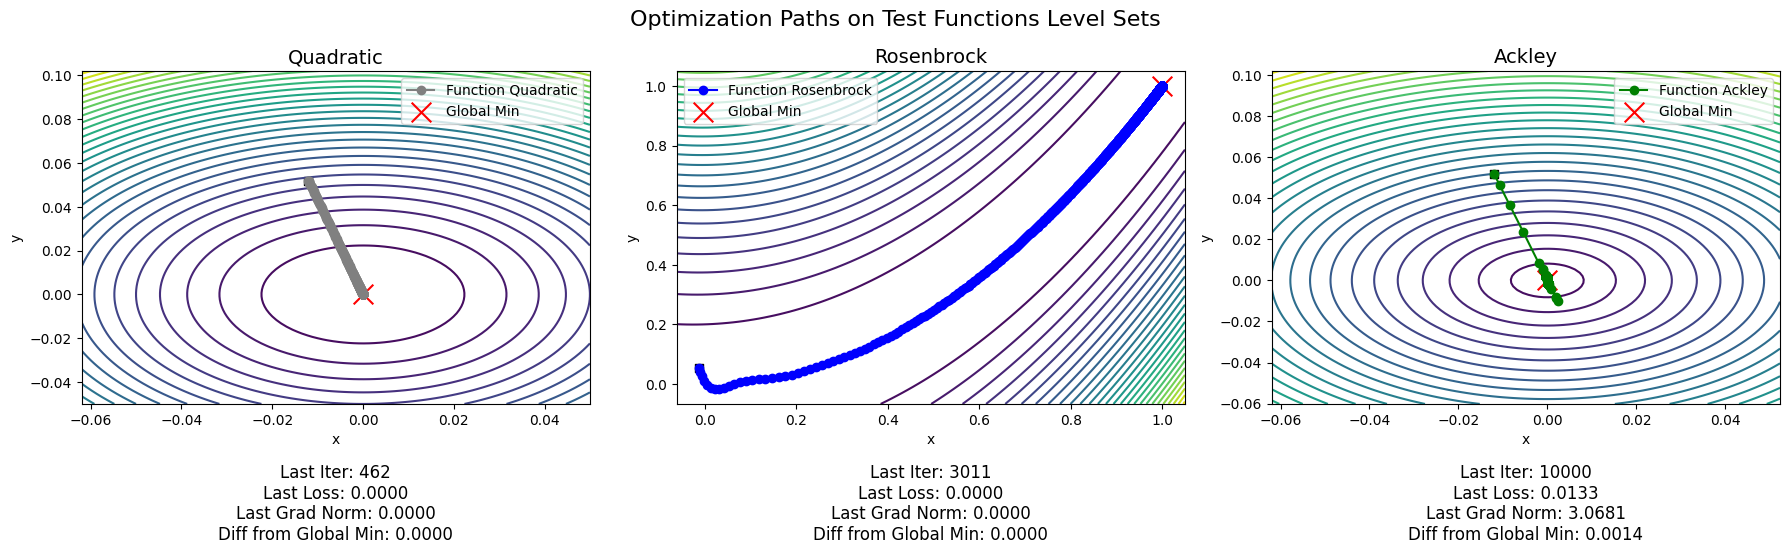

In [9]:
# Create an instance of TestFunctions and test the optimizer
test_functions = TestFunctions()

# Set optimizer parameters
theta_init = np.array([-0.012, 0.052])
epsilon = 0.001  # Learning rate
eta = 0.9  # Momentum coefficient
tol = 1e-6
max_iters = 10000

# Define optimizer wrapper function for plotting
def optimizer_wrapper(f):
    _, history = NAG(f, theta_init, epsilon, eta, tol, max_iters)
    return history

# Plot the optimization paths for test functions
test_functions.plot_contours(optimizer_wrapper)

In [10]:
'''grid_params = {
    "epsilon": [0.01, 0.001],
    "eta": [0.5, 0.8, 0.9],
    "max_iters": [1e3, 1e5]
}

def optimizer_wrapper(f, epsilon, eta, max_iters):
    _, history = NAG(f, theta_init, epsilon, eta, tol, int(max_iters))
    return history

for e in grid_params["epsilon"]:
    for m in grid_params["max_iters"]:
        for n in grid_params["eta"]:
            print(f"Running optimizer with epsilon={e}, eta={n}, max_iters={m}")
            test_functions.plot_contours(lambda f: optimizer_wrapper(f, e, n, m))
    '''

'grid_params = {\n    "epsilon": [0.01, 0.001],\n    "eta": [0.5, 0.8, 0.9],\n    "max_iters": [1e3, 1e5]\n}\n\ndef optimizer_wrapper(f, epsilon, eta, max_iters):\n    _, history = NAG(f, theta_init, epsilon, eta, tol, int(max_iters))\n    return history\n\nfor e in grid_params["epsilon"]:\n    for m in grid_params["max_iters"]:\n        for n in grid_params["eta"]:\n            print(f"Running optimizer with epsilon={e}, eta={n}, max_iters={m}")\n            test_functions.plot_contours(lambda f: optimizer_wrapper(f, e, n, m))\n    '

#### NAG applied to ELM

##### Synthetic Data

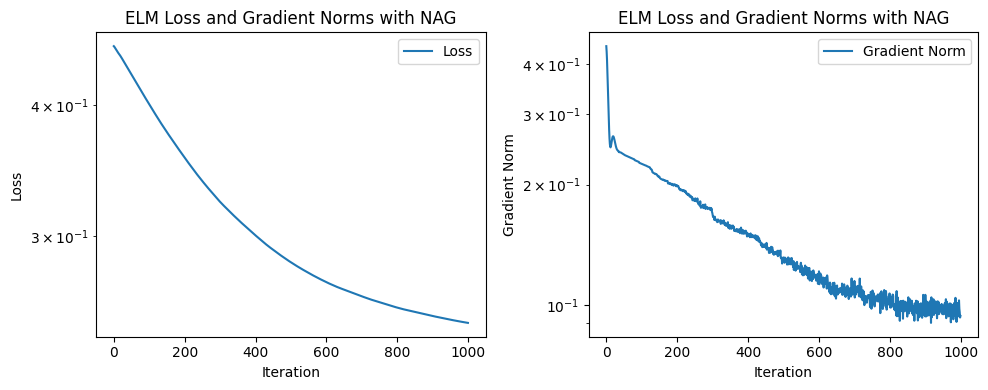

In [11]:
model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1, l1_lambda=0.01, activation='tanh', seed=42)

history = model.train(X_syn, y_syn, NAG, epsilon=1e-3, eta=0.9, tol=1e-6, max_iters=1000)
plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with NAG")

In [12]:
# TODO: gridsearch per l1, epsilon, eta, (max_iters?)

##### California Housing Data

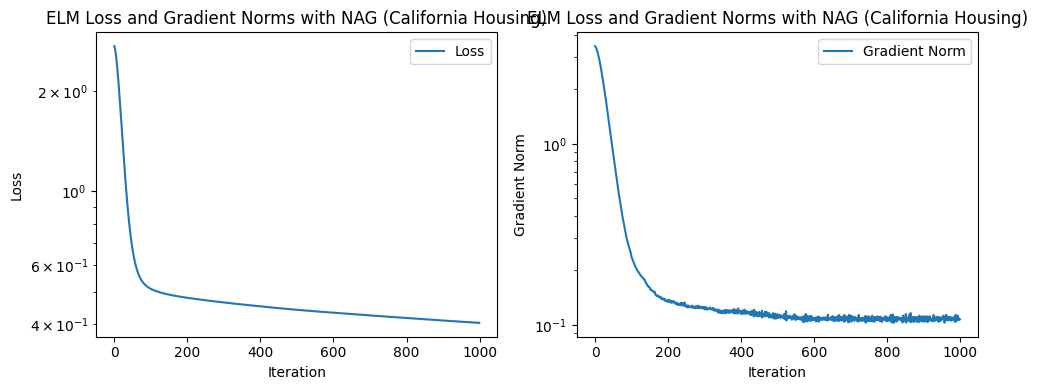

In [13]:
# CALIFORNIA HOUSING DATA
model = ELM(input_size=X_cal.shape[1], hidden_size=200, output_size=1, l1_lambda=0.01, activation='tanh', seed=42)

history = model.train(X_cal, y_cal, NAG, epsilon=1e-3, eta=0.9, tol=1e-6, max_iters=1000)
plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with NAG (California Housing)")

In [ ]:
# TODO: gridsearch per l1, epsilon, eta, (max_iters?)